In [1]:
%matplotlib inline
import os,sys,random

from parabola import ParabolicRegion as Parabola
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from igmm import IGMM, DynamicParameter
import time

In [2]:
def get_random_motor_set(system, n_samples):
    n_motor = system.n_motor
    raw_rnd_data = np.random.random((n_samples, n_motor))

    min_values = system.min_motor_values
    max_values = system.max_motor_values

    min_values = np.array(n_samples * [np.array(min_values)])
    max_values = np.array(n_samples * [np.array(max_values)])
    motor_commands = min_values + raw_rnd_data * (max_values - min_values)
    return motor_commands

def load_h5(file_name, system=None):
    # Keeping support to old datamanager files
    motor = pd.read_hdf(file_name, 'motor').as_matrix()
    sensor = pd.read_hdf(file_name, 'sensor').as_matrix()
    return motor, sensor

def evaluate_model(system, model, sensor_evaluation, axes=None):
    if axes is not None:
        plt.sca(axes)
    n_samples = sensor_evaluation.shape[0]
    x_dims = range(system.n_motor)
    y_dims = range(system.n_motor,system.n_motor+system.n_sensor)
    total_norm_error = 0.
    for i in range(n_samples):
        action = model.infer(x_dims,
                             y_dims,
                            sensor_evaluation[i,:])
        system.set_action(action)
        system.executeMotorCommand()
        if axes is not None:
            plt.scatter(sensor_evaluation[i,0],sensor_evaluation[i,1], marker = 'o', s = 3., color = 'b')
            plt.scatter(system.sensor_out[0],system.sensor_out[1],marker = 'x', s = 12., color = 'r')
        total_norm_error += np.linalg.norm(sensor_evaluation[i,:]-system.sensor_out)
    return total_norm_error/float(n_samples)

In [3]:
batch_size = 20
n_batches = 30

np.random.seed(123)

In [4]:
start_time = time.time()

n_models = 50

motor_evaluation, sensor_evaluation = load_h5('../parabola_v2_dataset.h5')
motor_data = {}
sensor_data = {}
system = Parabola()
for i in range(n_models):
    motor_data.update({i: get_random_motor_set(system, batch_size*n_batches)})
    sensor_data_tmp = np.zeros((batch_size*n_batches,system.n_sensor))
    for j in range( batch_size*n_batches):
            system.set_action(motor_data[i][j,:])
            system.executeMotorCommand()
            sensor_data_tmp[j,:] = system.sensor_out
    sensor_data.update({i: sensor_data_tmp})

evols = []
for  ii in range(n_models):
    ### System and Model
    system = Parabola()
    forgetting_factor = DynamicParameter(**{'function':'log',
                                                   'init':0.2,
                                                   'end':0.01,
                                                   'steps':n_batches})
    model = IGMM(min_components=3,
                 max_step_components=7,
                 max_components=20,
                 forgetting_factor=forgetting_factor)

    ### Train
    eval_evo = np.zeros((n_batches,))

    for i in range(n_batches):
        train_data = np.concatenate((motor_data[ii][i*batch_size:(i+1)*batch_size,:],
                                  sensor_data[ii][i*batch_size:(i+1)*batch_size,:]), axis=1)
        model.train(train_data)
        eval_evo[i] = evaluate_model(system, model, sensor_evaluation)
    evols += [eval_evo]
print("--- %s seconds ---" % (time.time() - start_time))


--- 1809.13100004 seconds ---


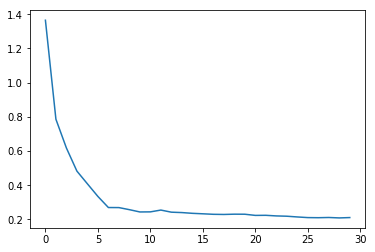

In [9]:
error = np.array(evols)
av_mean_error = np.mean(error, axis=0)
plt.plot(av_mean_error)

[ 1.36501995  0.78606258  0.61787413  0.48268982  0.40839655  0.33452187
  0.26966051  0.26932038  0.25715926  0.24375601  0.24429939  0.25481731
  0.24247702  0.24015722  0.23579049  0.23299713  0.23005647  0.22914791
  0.23073691  0.23046387  0.22364542  0.2241549   0.220595    0.2188488
  0.2145608   0.21080218  0.21013382  0.21142541  0.20891375  0.21094789]


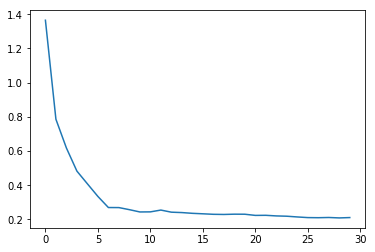

In [12]:
error = np.array(evols)
av_mean_error = np.mean(error, axis=0)
plt.plot(av_mean_error)
print av_mean_error

In [7]:
# fig1.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/2017 CCIA Regression Problem with IGMM/images/reg.eps',\
#             format='eps', dpi=1000, transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [8]:
batch_size = 15
n_batches = 40


[ 1.80463534  0.99558548  0.77154369  0.57619111  0.44238031  0.38391999
  0.31056466  0.27287746  0.2599877   0.24342677  0.22859661  0.2227161
  0.21750711  0.21347064  0.21038367  0.20304425  0.20590295  0.19780321
  0.19791444  0.19706652  0.19487253  0.19383922  0.19242601  0.18783428
  0.18909161  0.18828319  0.18310875  0.18612583  0.18920706  0.19335964
  0.19372064  0.19379133  0.19263216  0.19290289  0.19048273  0.19170222
  0.1890779   0.18796091  0.18312176  0.18231367]

SyntaxError: invalid syntax (<ipython-input-8-6678aa0a6371>, line 5)

In [ ]:
batch_size = 20
n_batches = 30

[ 1.36501995  0.78606258  0.61787413  0.48268982  0.40839655  0.33452187
  0.26966051  0.26932038  0.25715926  0.24375601  0.24429939  0.25481731
  0.24247702  0.24015722  0.23579049  0.23299713  0.23005647  0.22914791
  0.23073691  0.23046387  0.22364542  0.2241549   0.220595    0.2188488
  0.2145608   0.21080218  0.21013382  0.21142541  0.20891375  0.21094789]